In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
from jax.config import config
config.update("jax_enable_x64", True)

import morphine
import morphine_model
import pysynphot as S

import scipy
import scipy.ndimage as ndimage
from scipy.ndimage import zoom

import warnings
warnings.filterwarnings("ignore")

In [2]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 2000
pdiam2 = 0.13
osamp = 2

In [3]:
##################
# Define TOLIMAN #
# wavelength and #
# spectra info   #
##################

n_wavs = 100
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = np.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia for alpha cen A
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

In [4]:
#############################
# Stuff to get the optical  #
# system to work            #
#############################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

def get_toliman_pupil(size, file = 'Toliman_pupil.npy',path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load(file)
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [5]:
def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/np.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))


def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)

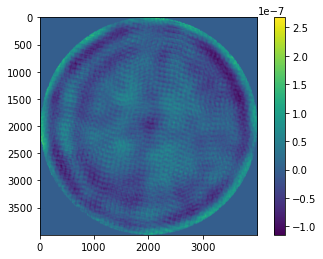

In [6]:
phaseMap = np.load('phaseMap_nm.npy')
plt.imshow(phaseMap)
plt.colorbar()

In [7]:
########################
# Define TOLIMAN pupil #
########################

toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,
                    telescope_diam=0.13, central_wav=central_wav,achromatic_pupil = True,
                    grating_amp=jnp.sqrt(0.1), pupil_file = 'Toliman_pupil.npy')

In [8]:
#######################################
# Define secondary mirror obscuration #
#######################################

trans = np.zeros((num_pix*osamp,num_pix*osamp))
y, x = np.indices((num_pix*osamp, num_pix*osamp))
r = np.sqrt((x-num_pix*osamp/2)**2 + (y-num_pix*osamp/2)**2)
trans[r<2000] = 1

secondary = morphine.InverseTransmission(morphine.CircularAperture(radius = 0.0071))


In [9]:
#######################################
# Define secondary mirror OPD effects #
#######################################


complex_optic = morphine.ArrayOpticalElement(transmission=trans,
                                          opd=phaseMap,
                                          name='Secondary Mirror')

In [10]:
aperture = morphine.CompoundAnalyticOptic(opticslist = [ toliman_Sidelobes, secondary],
                                          name = 'TOLIMAN pupil w/ secondary obscuration')

In [11]:
# no secondary mirror OPD effects #

plt.figure(figsize = (10,10))

TOLIMAN_noPolish = morphine.OpticalSystem()
TOLIMAN_noPolish.add_pupil(toliman_Sidelobes)
TOLIMAN_noPolish.add_pupil(secondary)
TOLIMAN_noPolish.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
#TOLIMAN_noPolish.display(what = 'both')


<Figure size 720x720 with 0 Axes>

In [12]:
#TOLIMAN_Polish.planes

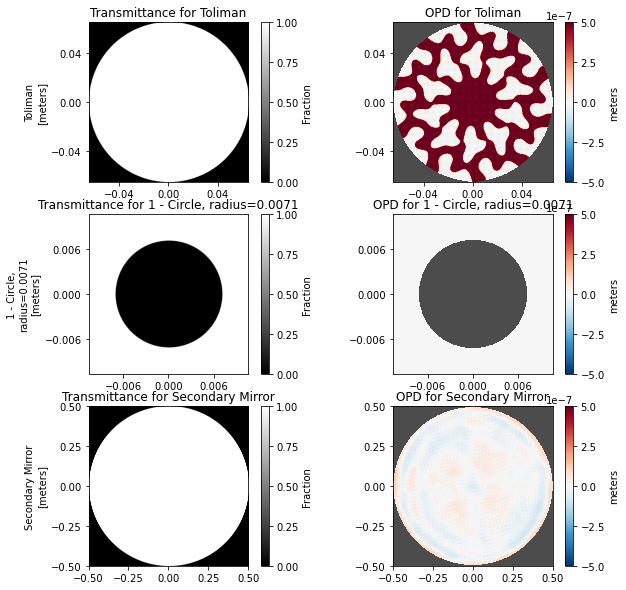

In [13]:
# with secondary mirror OPD effects #


plt.figure(figsize = (10,10))

TOLIMAN_Polish = morphine.OpticalSystem()
TOLIMAN_Polish.add_pupil(toliman_Sidelobes)
TOLIMAN_Polish.add_pupil(secondary)
TOLIMAN_Polish.add_pupil(complex_optic)
TOLIMAN_Polish.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
TOLIMAN_Polish.display(what = 'both')

In [107]:
%%time
imageNoPolish = get_bb_psf(0,0,TOLIMAN_noPolish,wavs, weights = weights_A)
imagePolish = get_bb_psf(0,0,TOLIMAN_Polish,wavs, weights = weights_A)


CPU times: user 9min 52s, sys: 1min 11s, total: 11min 3s
Wall time: 2min 29s


In [108]:
norm = np.max(imageNoPolish[130:330, 130:330])
print(np.sum(imageNoPolish[130:330, 130:330]))
print(np.sum(imagePolish[130:330, 130:330]))
imageNoPolish = imageNoPolish[130:330, 130:330]/np.max(imageNoPolish[130:330, 130:330])
imagePolish = imagePolish[130:330, 130:330]/norm

# [865:1135, 865:1135] [130:350, 130:350]

0.023356050726853834
0.02303441896032206


Min: -0.02
Max: 0.08
SSE: 4.99


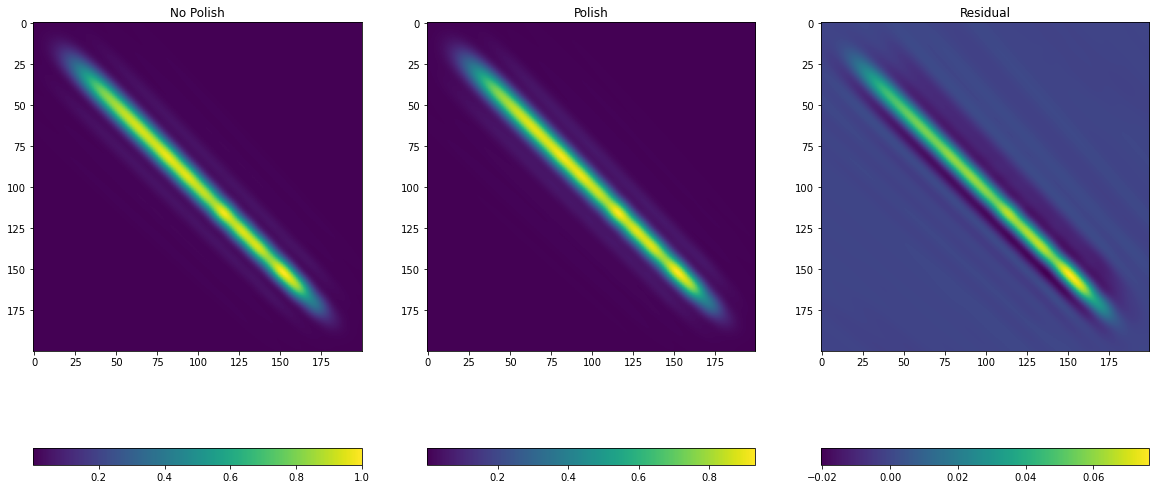

In [109]:
plt.figure(figsize = (20,12))
plt.subplot(1,3,1)
plt.imshow(imageNoPolish)
plt.colorbar( orientation="horizontal")
plt.title('No Polish')

plt.subplot(1,3,2)
plt.imshow(imagePolish)
plt.colorbar( orientation="horizontal")
plt.title('Polish')

plt.subplot(1,3,3)
plt.imshow((imageNoPolish - imagePolish))
plt.colorbar( orientation="horizontal") 
plt.title('Residual')

the_min = np.min(imageNoPolish - imagePolish)
the_max = np.max(imageNoPolish - imagePolish)
sse = np.sum(((imageNoPolish - imagePolish)**2))

print('Min: {:.2f}'.format(the_min))
print('Max: {:.2f}'.format(the_max))
print('SSE: {:.2f}'.format(sse))

-1.2
Note distribution is slighlty skewed to a negative change - could mean a slighlty longer integration time needed
CPU times: user 26.8 ms, sys: 118 µs, total: 26.9 ms
Wall time: 26.6 ms


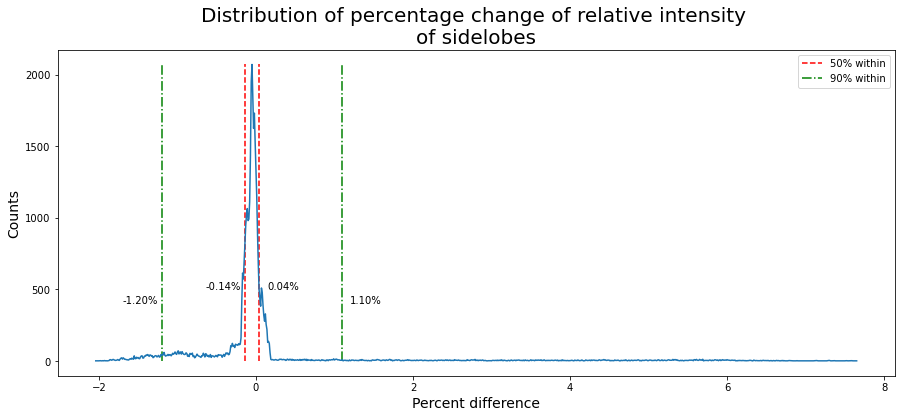

In [113]:
%%time

diff = imageNoPolish - imagePolish
diff_rounded = np.round(diff, 4)
diff_vec = diff_rounded.reshape(-1,1)
unique, counts = np.unique(diff_vec, return_counts = True)
unique *= 100 # turn to percentage

total_counts = np.sum(counts)

half_counts = int(np.floor(total_counts/2))
ninety_counts = int(np.floor(total_counts * (9/10)))
counts_within = 0

max_count_loc = np.where(counts == np.max(counts))[0][0]

left = max_count_loc 
right = max_count_loc

while counts_within < half_counts:
    counts_within = np.sum(counts[left:right])
    left  -= 1
    right += 1
    
left90  = left 
right90 = right

while counts_within < ninety_counts:
    counts_within = np.sum(counts[left90:right90])
    left90  -= 1
    right90 += 1

plt.figure(figsize = (15,6))
plt.plot(unique, counts)
plt.vlines([unique[left], unique[right]], 0, np.max(counts), ls = '--', color = 'red', label = '50% within')
plt.vlines([unique[left90], unique[right90]], 0, np.max(counts), ls = '-.', color = 'green', label = '90% within')
plt.annotate('{:.2f}%'.format(unique[left]), (unique[left]-0.5,500))
plt.annotate('{:.2f}%'.format(unique[right]), (unique[right]+0.1,500))
plt.annotate('{:.2f}%'.format(unique[left90]), (unique[left90]-0.5,400))
plt.annotate('{:.2f}%'.format(unique[right90]), (unique[right90]+0.1,400))

print(unique[left90])
plt.legend()
plt.xlabel('Percent difference', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('Distribution of percentage change of relative intensity \nof sidelobes', fontsize = 20)

print('Note distribution is slighlty skewed to a negative change - could mean a slighlty longer integration time needed')




In [17]:
newImage = (imageNoPolish - imagePolish)
the_min = np.min(newImage)
the_max = np.max(newImage)
rms = np.sqrt(np.mean((newImage)**2))

print('Min: {:.2f}'.format(the_min))
print('Max: {:.2f}'.format(the_max))
print('RMS: {:.2f}'.format(rms))

Min: -0.21
Max: 0.22
RMS: 0.03


In [18]:
#test:
print(stop)

#########################
# Ignore following code #
#########################

NameError: name 'stop' is not defined

In [ ]:
data1 = np.load('Toliman_pupil.npy')
data1v1 = get_toliman_pupil(osamp*num_pix)
data2 = np.load('phaseMap_nm.npy')
data3 = np.load('pseudoPupil550.npy')
#print(np.shape(data1))
plt.figure()
plt.imshow(data2*1e9/550)
plt.colorbar()
plt.figure()
plt.imshow(np.real(data1v1))
plt.colorbar()
plt.figure()
plt.imshow(np.angle(data1v1+data2*1e9/550))
plt.colorbar()

plt.figure()


In [ ]:
plt.figure(figsize = (12,8))
plt.subplot(1,3,1)
plt.imshow(np.real(data3))
plt.title('np.real')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(np.imag(data3))
plt.title('np.imag')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow(np.angle(data3))
plt.title('np.angle')
plt.colorbar(orientation = 'horizontal')

plt.figure(figsize = (12,8))
plt.subplot(1,3,1)
plt.imshow(np.real(data1v1))
plt.title('np.real')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(np.imag(data1v1))
plt.title('np.imag')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow(np.angle(data1v1))
plt.title('np.angle')
plt.colorbar(orientation = 'horizontal')

plt.figure(figsize = (12,8))
plt.subplot(1,3,1)
plt.imshow(np.real(data3) - np.real(data1v1))
plt.title('np.real')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(np.imag(data3) - np.imag(data1v1))
plt.title('np.imag')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow(np.angle(data3) - np.angle(data1v1))
plt.title('np.angle')
plt.colorbar(orientation = 'horizontal')

In [ ]:
image_array = 1j*np.ones((4000,4000)) + np.real(data3)
image_array2 = 1j*np.ones((4000,4000)) + np.real(data1v1)


In [ ]:
plt.figure()
plt.imshow(np.angle(image_array))
plt.colorbar()

plt.figure()
plt.imshow(np.angle(image_array2))
plt.colorbar()